# Lab 3 — recommender systems

In [17]:
import json
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt

import pickle
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool
from matplotlib.colors import rgb2hex

%matplotlib inline
plt.style.use("ggplot")

In [10]:
def add(x, y):
    return x + y

What does the data look like?

In [2]:
!hdfs dfs -cat /ix/ml-20m/ratings.txt | tail -n 2

{"movieId": 70286, "userId": 138493, "timestamp": 1258126944, "rating": 5.0}
{"movieId": 71619, "userId": 138493, "timestamp": 1255811136, "rating": 2.5}


In [3]:
data = sc.textFile("/ix/ml-20m/ratings.txt").map(json.loads)

## 3.4 Basic Statistics

In [4]:
user_ratings = data.map(lambda d: (d['userId'], d['rating'])).collect()

In [14]:
ratings_per_user = data.map(lambda d: (d['userId'], 1)).reduceByKey(add).map(lambda d: d[1]).collect()

In [15]:
ratings_per_item = data.map(lambda d: (d['movieId'], 1)).reduceByKey(add).map(lambda d: d[1]).collect()

Text(0.5,1,'Histogram of how many items have how many ratings')

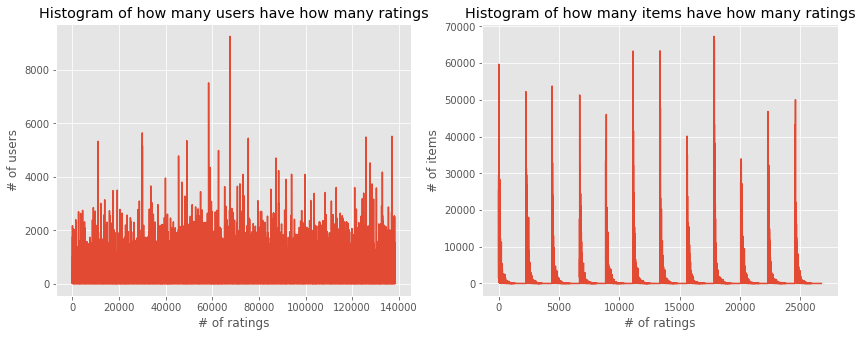

In [16]:
plt.figure(num=None, figsize=(14, 5))

plt.subplot(1,2,1)
plt.plot(ratings_per_user)
plt.xlabel("# of ratings")
plt.ylabel("# of users")
plt.title("Histogram of how many users have how many ratings")

plt.subplot(1,2,2)
plt.plot(ratings_per_item)
plt.xlabel("# of ratings")
plt.ylabel("# of items")
plt.title("Histogram of how many items have how many ratings")

The number of ratings are clearly not balanced uniformly, since many users/items have almost no ratings, while others have a lot.
## 3.5 Partitioning the dataset

In [21]:
with open('my-ratings.txt') as f:
    my_ratings = sc.parallelize([json.loads(line) for line in f.read().splitlines()])

In [22]:
data = data.union(my_ratings)

Split the data into a training and a validation set

In [23]:
training = data.filter(lambda x: (x['timestamp'] % 10) > 1).map(lambda x: (x['userId'], x['movieId'], x['rating']))
validation = data.map(lambda x: (x['userId'], x['movieId'], x['rating'])).subtract(training).persist()

In [45]:
# function to calculate mean square error between a set of prediction and a set of validation elements
def mserror(prediction, validation):
    dev, count = prediction.map(lambda x: ((x[0], x[1]), x[2]))\
                    .join(validation.map(lambda x: ((x[0], x[1]), x[2])))\
                    .map(lambda x: (x[0][0], (x[1][0] - x[1][1])**2))\
                    .groupByKey()\
                    .map(lambda x: (sqrt(sum(x[1])/len(x[1])), 1))\
                    .reduce(lambda x, y: (x[0]+y[0], x[1]+y[1]))
    return dev / count

## 3.6 Baseline model

In [92]:
global_mean = training.map(lambda x: (x[2], 1)).reduce(lambda x, y: (x[0] + y[0], x[1] + y[1]))
global_mean = global_mean[0] / global_mean[1]
print("Global mean is", global_mean)

Global mean is 3.5255076817576816


In [93]:
user_bias = training.map(lambda x: (x[0], x[2] - global_mean))\
                    .groupByKey()\
                    .map(lambda x: (x[0], 0 if sum(x[1]) == 0 else sum(x[1])/len(x[1])))

In [94]:
u_b_local = dict(user_bias.collect())

In [95]:
item_bias = training.map(lambda x: (x[1], x[2] - u_b_local[x[0]] - global_mean))\
                    .groupByKey()\
                    .map(lambda x: (x[0], 0 if sum(x[1]) == 0 else sum(x[1])/len(x[1])))

In [96]:
i_b_local = dict(item_bias.collect())

In [97]:
users = data.map(lambda x: x['userId']).distinct().count()
products = data.map(lambda x: x['movieId']).distinct().count()
print("Number of parameters:", users + products)

Number of parameters: 165238


Predict the rating of every user / movie pair in the validation set.

In [105]:
predictions = validation.map(lambda x: (x[0], x[1], global_mean + u_b_local.get(x[0], 0) + i_b_local.get(x[1], 0)))

## 3.7 Evaluation

In [106]:
baseline_error = mserror(predictions, validation)
print("Mean square error:", baseline_error)

Mean square error: 0.8683781169845344


# 3.2.2 Matrix-factorization model
## 3.8 Regularization
The lower the rank, the less we use the information that is actually given to us. We risk overgeneralisation.<br>
The higher the rank, the more we assume that our data is representative for the real world. We risk overfitting.<br>
We use the rank in between 5 and 25: 15.

In [78]:
from pyspark.mllib.recommendation import ALS

In [79]:
rank = 15

Lambda 1e-10

In [98]:
model = ALS.train(training, rank, lambda_=1e-4)

In [99]:
predictions_model = model.predictAll(validation.map(lambda x: (x[0], x[1])))

In [100]:
print("Mean square error with lambda", 1e-4, ":", mserror(predictions_model, validation))

Mean square error with lambda 0.0001 : 0.9917269252642622


The error is above our baseline model error. This is clearly disappointing. We need to cross-validate lambda to find it's optimal value with our chosen rank.

Lambda = 10

In [101]:
model2 = ALS.train(training, rank, lambda_=10.0)

In [102]:
predictions_model2 = model2.predictAll(validation.map(lambda x: (x[0], x[1])))

In [103]:
print("Mean square error with lambda", 10, ":", mserror(predictions_model2, validation))

Mean square error with lambda 10 : 3.746888119582086


This result is way worse than our baseline model error, so the optimal lambda must be closer to 0.0001 than to 10.

#### Find optimal lambda
We expect the optimal lambda to be between 1e-2 and 1.

In [86]:
errors = []
for l in np.linspace(-2, 0, num=4):
    l = 10 ** l
    model_l = ALS.train(training, rank, lambda_=l)
    predictions_l = model_l.predictAll(validation.map(lambda x: (x[0], x[1])))
    errors.append(mserror(predictions_l, validation))

In [107]:
print(errors)
l = 10**np.linspace(-2, 0, num=4)[np.argmin(errors)]
print("Best lamda approx.", l)
print("Improvement of ", baseline_error - min(errors),"or", (baseline_error/min(errors)-1)*100,"%")

[0.8557738253335343, 0.8240759707295527, 0.8493308374347794, 1.327690605853009]
Best lamda approx. 0.0464158883361
Improvement of  0.044302146254981634 or 5.375978408369431 %


## 3.9 Recommendation

In [108]:
movies = sc.textFile("/ix/ml-20m/movies.txt").map(json.loads)

In [109]:
m = movies.map(lambda x: (x['movieId'], x['title'])).collectAsMap()

In [110]:
model = ALS.train(data.map(lambda x: (x['userId'], x['movieId'], x['rating'])), rank=rank, lambda_=l)

In [111]:
for u, m2, r in model.recommendProducts(123, 10):
    print(m[m2])

Jim Jefferies: Alcoholocaust (2010)
Punk in London (1977)
Low Life, The (1995)
Animal Love (Tierische Liebe) (1996)
Isadora (1968)
Peppermint Soda (Diabolo menthe) (1977)
Marius (1931)
World According to Monsanto, The (monde selon Monsanto, Le) (2008)
Autobiography of Miss Jane Pittman, The (1974)
Outrageous Class (Hababam sinifi) (1975)


In [112]:
for u, m2, r in model.recommendProducts(138494, 10):
    print(m[m2])

Nine Lives of Tomas Katz, The (2000)
Patrice O'Neal: Elephant in the Room (2011)
Alice in Wonderland (1985)
Crazy Class Wakes Up, The (Hababam sinifi uyaniyor) (1977)
When Nietzsche Wept (2007)
Spud (2010)
Up! (1976)
G.I. Joe: A Real American Hero (G.I. Joe: The MASS Device) (1983)
Chameleon (Kaméleon) (2008)
You Can't Win 'Em All (1970)


## 3.10 Visualisation

In [113]:
selected_movies = pickle.load(open('selected-movies.pickle', 'rb'), encoding='utf-8')

In [114]:
model_vis = ALS.train(data.map(lambda x: (x['userId'], x['movieId'], x['rating'])), rank=2, lambda_=l)
features = model_vis.productFeatures().collectAsMap()

In [115]:
d = dict(x=[], y=[], name=[], score=[], color=[])

for m in selected_movies:
    coords = features[m[0]]
    d['x'].append(coords[0])
    d['y'].append(coords[1])
    d['name'].append(m[1])
    d['score'].append(m[2])
    d['color'].append(rgb2hex(plt.get_cmap('RdYlGn')(m[2])[:3]))
src = ColumnDataSource(d)
hover = HoverTool(
        tooltips=[
            ("name", "@name"),
            ("RT score","@score"),
        ]
    )

p = figure(tools=[hover], title="Movie plotted onto 2 principal directions", 
           x_axis_label='Quality (good -> bad)',y_axis_label='Romance (little -> a lot)')

p.circle('x', 'y', size=20, source=src, color='color')
output_file("recsys.html")

show(p)

In [116]:
import IPython
IPython.display.HTML(filename="recsys.html")